This notebook is used to compare the performance of Feature Selection using FeatureWiz.

We are using RDKit and Mordered Descriptors. Both with all features and then with selected best features.

The higher the corr_limit, the higher the number of features selected using FeatureWiz.

In [1]:
import os
import pandas as pd  
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 
from featurewiz import FeatureWiz
from xai4chem import DatamolDescriptor
from xai4chem import RDkitClassicalDescriptor
from xai4chem import MordredDescriptor
from xai4chem import Regressor

2024-04-09 07:56:41.213479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Imported lazytransform v1.16. 

Imported featurewiz 0.5.7. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


### Data

In [2]:
data = pd.read_csv("../data/plasmodium_falciparum_3d7_ic50.csv")

# SMILES and target values
smiles = data["smiles"]
target = data["pchembl_value"]

pchembl_value is the preferred y variable. It's the -log transformation of the IC50 value(in nM).

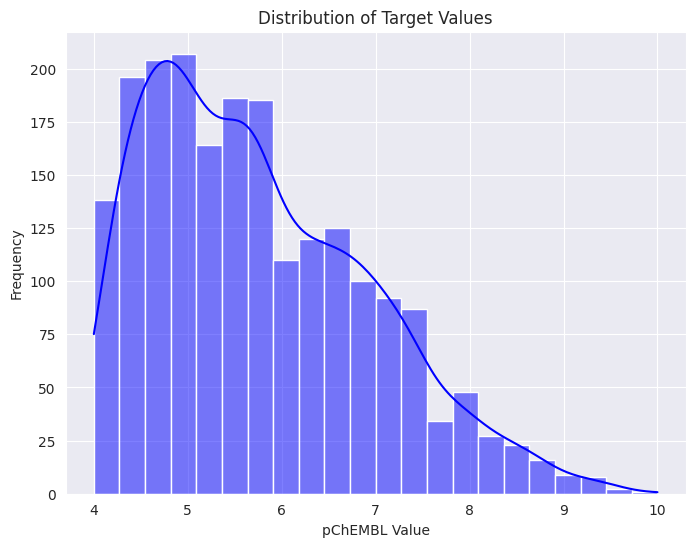

In [3]:
# Plot distribution of target values
plt.figure(figsize=(8, 6))
sns.histplot(target, kde=True, color='blue')
plt.title('Distribution of Target Values')
plt.xlabel('pChEMBL Value')
plt.ylabel('Frequency')
plt.show()


In [4]:
# Split data into training and test sets
smiles_train, smiles_valid, y_train, y_valid = train_test_split(smiles, target, test_size=0.2, random_state=42)

# Reset indices
smiles_train.reset_index(drop=True, inplace=True)
smiles_valid.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

### Feature transformation: Descriptors

In [5]:
def calculate_descriptors(descriptor_type):
    """
    Calculate descriptors using the specified descriptor type.
    Args:
    - descriptor_type: String indicating the descriptor type ('DataMol', 'RDKit', or 'Mordred')
    - smiles_train: List of SMILES strings for training
    - smiles_valid: List of SMILES strings for validation. Default is None.
    Returns:
    - tuple: Transformed descriptors for training and validation
    """
    if descriptor_type == 'DataMol':
        descriptor = DatamolDescriptor()
    elif descriptor_type == 'RDKit':
        descriptor = RDkitClassicalDescriptor()
    elif descriptor_type == 'Mordred':
        descriptor = MordredDescriptor()
    else:
        raise ValueError("Invalid descriptor type. Please choose 'Datamol', 'RDKit', or 'Mordred'.")
    
    descriptor.fit(smiles_train)
    train_transformed = descriptor.transform(smiles_train)
    valid_transformed = descriptor.transform(smiles_valid) 
    
    return train_transformed, valid_transformed

### Helper Functions

In [6]:
# Function to generate output folder path for each descriptor set
def set_output_folder(descriptor_name, features, use_default_params):
    folder_name = f"{descriptor_name}_{features}_default_params_{use_default_params}"
    output_folder_path= os.path.join("../assets", folder_name)
    os.makedirs(output_folder_path, exist_ok=True)
    print('Output folder:', output_folder_path)
    return output_folder_path

In [7]:
def train_evaluate(X_train, y_train_values, X_valid, y_valid_values, results_folder, select_features=True, default_params=True):
    if select_features: 
       # Select Features
        fwiz = FeatureWiz(corr_limit=0.80, feature_engg='', transform_target=False, category_encoders='',
                          dask_xgboost_flag=False, nrows=None, verbose=0)
        
        X_train_transformed, _ = fwiz.fit_transform(X_train, y_train_values)
        X_valid_transformed = fwiz.transform(X_valid)
        print("Selected Features: ", fwiz.features)
    else:
        X_train_transformed = X_train
        X_valid_transformed = X_valid    
    
    # Instantiate the regressor    
    regressor = Regressor(output_folder=results_folder, algorithm='xgboost')  
    
        
    # Train the model 
    regressor.fit(X_train_transformed, y_train_values, default_params=default_params)

    # Evaluate model
    evaluation = regressor.evaluate(X_valid_transformed, y_valid_values)#returns scores of evaluation metrics
    print(evaluation) 

    # Explain the model     
    regressor.explain(X_train_transformed)
    
    return results_folder

In [8]:
# View all performance plots in the output folder
def print_images_in_folder(folder): 
    files = os.listdir(folder) 
    image_files = [file for file in files if file.endswith('.png')] 
    
    num_images = len(image_files)
    num_rows = (num_images + 1) // 2  
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))
    axes = axes.flatten() 
     
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder, img_file)
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(img_file)
     
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

## RDKit Descriptors 

In [9]:
smiles_train_transformed_rdkit, smiles_valid_transformed_rdkit = calculate_descriptors('RDKit')

100%|██████████| 417/417 [00:08<00:00, 49.78it/s]


### All Features

Because binning was applied, some rdkit descriptors were dropped. So in total, all features used from rdkit descriptors are 198.

#### Default Parameters

In [10]:
rdkit_all_features_default_params = set_output_folder('RDKit', 'all_features', use_default_params=True)

train_evaluate(X_train=smiles_train_transformed_rdkit, y_train_values=y_train,
               X_valid=smiles_valid_transformed_rdkit, y_valid_values=y_valid,
               results_folder=rdkit_all_features_default_params,
               select_features=False, default_params=True)

Output folder: ../assets/RDKit_all_features_default_params_True
{'Mean Squared Error': 0.4751, 'Root Mean Squared Error': 0.6893, 'Mean Absolute Error': 0.4862, 'R-squared Score': 0.6415, 'Explained Variance Score': 0.6418}


'../assets/RDKit_all_features_default_params_True'

With 198 rdkit features and default parameters of xgboost, the r2_score achieved is **0.6415**

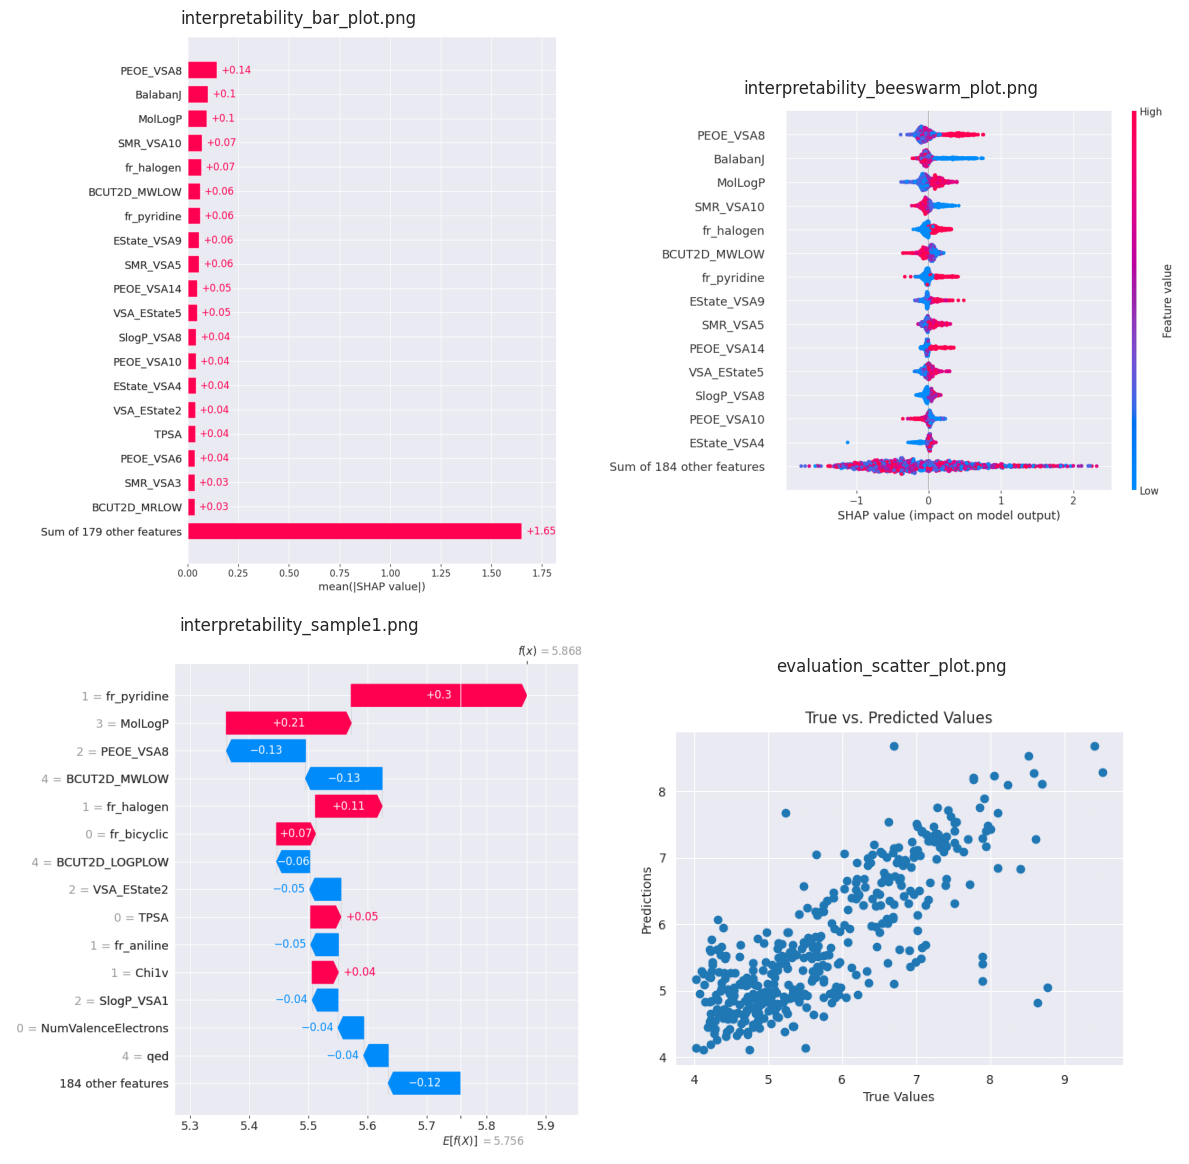

In [11]:
print_images_in_folder(rdkit_all_features_default_params)

#### With Optuna

In [12]:
rdkit_all_features_optimized_params = set_output_folder('RDKit', 'all_features', use_default_params=False)
train_evaluate(X_train=smiles_train_transformed_rdkit, y_train_values=y_train, 
               X_valid=smiles_valid_transformed_rdkit,y_valid_values=y_valid, 
               results_folder=rdkit_all_features_optimized_params, 
               select_features=False, default_params=False)

[I 2024-04-09 07:58:19,578] A new study created in memory with name: no-name-182c4b27-c703-40f1-bb3a-1cab409a25f8


Output folder: ../assets/RDKit_all_features_default_params_False


[I 2024-04-09 07:58:21,322] Trial 0 finished with value: 0.6235741690329245 and parameters: {'lambda': 3, 'alpha': 0, 'gamma': 6, 'learning_rate': 0.19710655583668016, 'colsample_bytree': 0.7, 'colsample_bynode': 0.5, 'n_estimators': 69, 'min_child_weight': 90, 'max_depth': 6, 'subsample': 0.8, 'random_state': 42}. Best is trial 0 with value: 0.6235741690329245.
[I 2024-04-09 07:58:22,594] Trial 1 finished with value: 0.6705973023766869 and parameters: {'lambda': 2, 'alpha': 2, 'gamma': 7, 'learning_rate': 0.11712296145645205, 'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'n_estimators': 128, 'min_child_weight': 81, 'max_depth': 3, 'subsample': 0.4, 'random_state': 0}. Best is trial 0 with value: 0.6235741690329245.
[I 2024-04-09 07:58:23,209] Trial 2 finished with value: 0.6705058452961322 and parameters: {'lambda': 1, 'alpha': 2, 'gamma': 8, 'learning_rate': 0.5556445035185534, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8, 'n_estimators': 175, 'min_child_weight': 41, 'max_dep

Best parameters for XGBoost: {'lambda': 3, 'alpha': 2, 'gamma': 0, 'learning_rate': 0.11095538170620421, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'n_estimators': 155, 'min_child_weight': 12, 'max_depth': 10, 'subsample': 0.8, 'random_state': 42}
{'Mean Squared Error': 0.399, 'Root Mean Squared Error': 0.6317, 'Mean Absolute Error': 0.4516, 'R-squared Score': 0.6989, 'Explained Variance Score': 0.6989}


'../assets/RDKit_all_features_default_params_False'

With 198 rdkit features and using optuna with 200 trials, the r2_score achieved is; **0.6989**. Higher than when trained with default parameters.

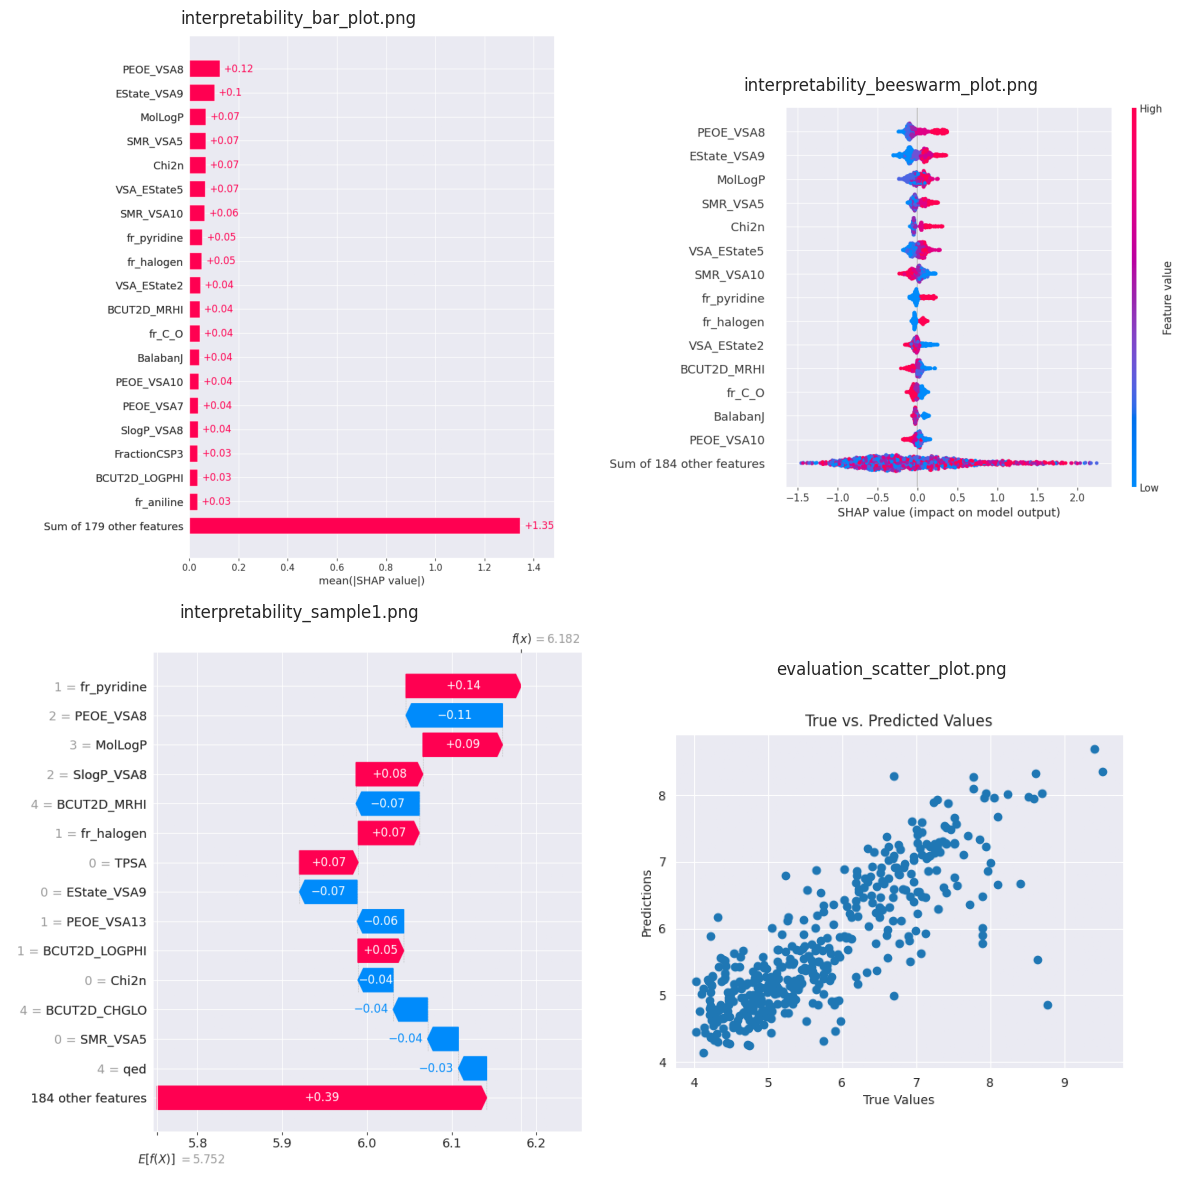

In [13]:
print_images_in_folder(rdkit_all_features_optimized_params)

PEOE_VSA8 is the top contributing feature.

### Select Features

Out of 198 features from rdkit, a corr_limit of 0.80 gives us a total of **49 selected features**.

#### Train with Default Parameters

In [14]:
rdkit_select_features_default_params = set_output_folder('RDKit', 'select_features', use_default_params=True)
    
train_evaluate(X_train=smiles_train_transformed_rdkit, y_train_values=y_train, 
               X_valid=smiles_valid_transformed_rdkit, y_valid_values=y_valid,
               results_folder= rdkit_select_features_default_params, 
               select_features=True, default_params=True)

Output folder: ../assets/RDKit_select_features_default_params_True
featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []
Loaded input data. Shape = (1665, 198)
#### Starting featurewiz transform for train data ####
    Single_Label Regression problem 
Shape of dataset: (1665, 198). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (1665, 198)
    Single_Label Regression problem 
Starting SULOV with 131 features...
    there are no null values in dataset...
    there are no null values in target column...
Completed SULOV. 95 features selected
Performing recursive XGBoost feature selection from 95 fea

'../assets/RDKit_select_features_default_params_True'

With 49 selected rdkit features and default parameters of xgboost, the r2_score achieved is **0.6561**. This is slightly higher than when trained with 198 features and default params.

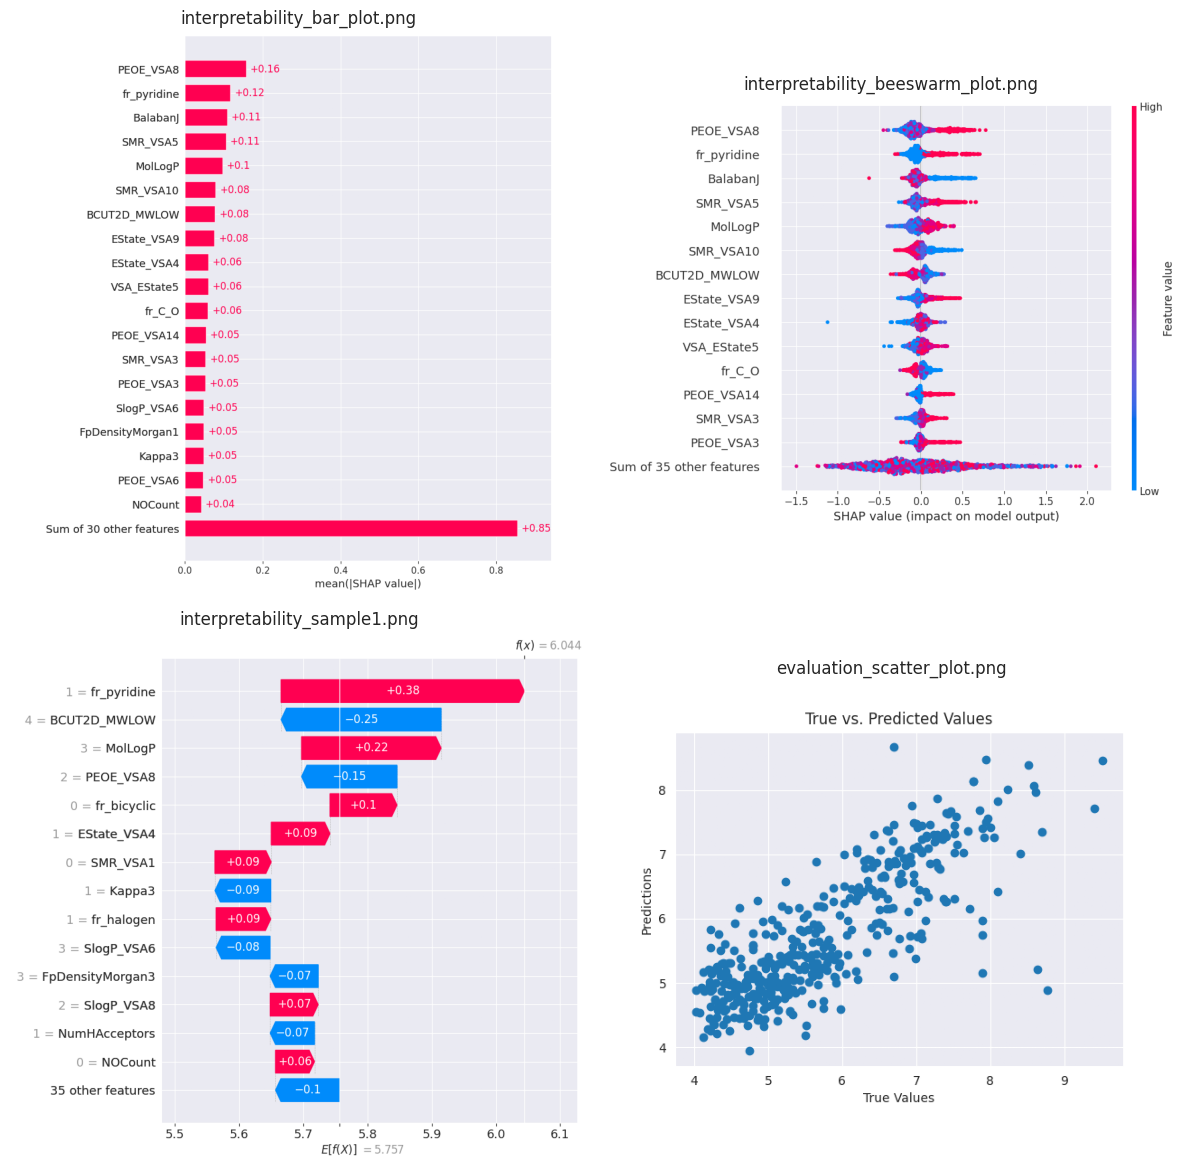

In [15]:
print_images_in_folder(rdkit_select_features_default_params)

#### Train with Optuna

In [16]:
rdkit_select_features_optimized_params = set_output_folder('RDKit', 'select_features', use_default_params=False)
train_evaluate(X_train=smiles_train_transformed_rdkit, y_train_values=y_train,
               X_valid=smiles_valid_transformed_rdkit, y_valid_values=y_valid,
               results_folder=rdkit_select_features_optimized_params, 
               select_features=True, default_params=False)

Output folder: ../assets/RDKit_select_features_default_params_False
featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []
Loaded input data. Shape = (1665, 198)
#### Starting featurewiz transform for train data ####
    Single_Label Regression problem 
Shape of dataset: (1665, 198). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (1665, 198)
    Single_Label Regression problem 
Starting SULOV with 131 features...
    there are no null values in dataset...
    there are no null values in target column...
Completed SULOV. 95 features selected
Performing recursive XGBoost feature selection from 95 fe

[I 2024-04-09 08:02:24,280] A new study created in memory with name: no-name-bf7c9160-81ce-408a-8ebd-c0898c939387


    time taken to run entire featurewiz = 3 second(s)
Recursive XGBoost selected 49 features...
#### Starting featurewiz transform for test data ####
Loaded input data. Shape = (417, 198)
#### Starting lazytransform for test data ####
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (417, 198)
Returning dataframe with 49 features 
Selected Features:  ['PEOE_VSA8', 'BalabanJ', 'MolLogP', 'fr_pyridine', 'SMR_VSA5', 'EState_VSA9', 'PEOE_VSA14', 'PEOE_VSA3', 'VSA_EState2', 'fr_bicyclic', 'SMR_VSA10', 'Chi2n', 'BCUT2D_MWLOW', 'VSA_EState9', 'VSA_EState8', 'MaxAbsEStateIndex', 'SMR_VSA3', 'PEOE_VSA10', 'fr_halogen', 'PEOE_VSA7', 'PEOE_VSA6', 'VSA_EState5', 'SMR_VSA6', 'NumHDonors', 'MinAbsPartialCharge', 'SMR_VSA1', 'EState_VSA4', 'MinPartialCharge', 'VSA_EState3', 'NumHAcceptors', 'SlogP_VSA6', 'fr_Ar_N', 'SlogP_VSA8', 'fr_NH1', 'fr_NH0', 'FpDensityMorgan3', 'NumAromaticRings', 'BCUT2D_CHGLO', 'Kappa3', 'NumAliphaticCarbocycles', 'Chi2v', 'fr_C_O', 'NOCoun

[I 2024-04-09 08:02:24,625] Trial 0 finished with value: 0.6561266804027843 and parameters: {'lambda': 2, 'alpha': 2, 'gamma': 4, 'learning_rate': 0.337084769586389, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'n_estimators': 164, 'min_child_weight': 68, 'max_depth': 16, 'subsample': 0.6, 'random_state': 0}. Best is trial 0 with value: 0.6561266804027843.
[I 2024-04-09 08:02:24,964] Trial 1 finished with value: 0.6494528805386196 and parameters: {'lambda': 1, 'alpha': 5, 'gamma': 4, 'learning_rate': 0.3347597376676843, 'colsample_bytree': 0.4, 'colsample_bynode': 1.0, 'n_estimators': 107, 'min_child_weight': 88, 'max_depth': 7, 'subsample': 0.6, 'random_state': 42}. Best is trial 1 with value: 0.6494528805386196.
[I 2024-04-09 08:02:25,107] Trial 2 finished with value: 0.7287379659475149 and parameters: {'lambda': 2, 'alpha': 0, 'gamma': 10, 'learning_rate': 0.7090012001299428, 'colsample_bytree': 0.6, 'colsample_bynode': 0.8, 'n_estimators': 115, 'min_child_weight': 92, 'max_dep

Best parameters for XGBoost: {'lambda': 5, 'alpha': 0, 'gamma': 0, 'learning_rate': 0.14810501777012594, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6, 'n_estimators': 86, 'min_child_weight': 7, 'max_depth': 15, 'subsample': 1.0, 'random_state': 0}
{'Mean Squared Error': 0.3905, 'Root Mean Squared Error': 0.6249, 'Mean Absolute Error': 0.4488, 'R-squared Score': 0.7053, 'Explained Variance Score': 0.7054}


'../assets/RDKit_select_features_default_params_False'

With 49 selected rdkit features and using optuna with 200 trials, the r2_score achieved is; **0.7053**. This is slightly higher than when trained with 198 features and optuna.

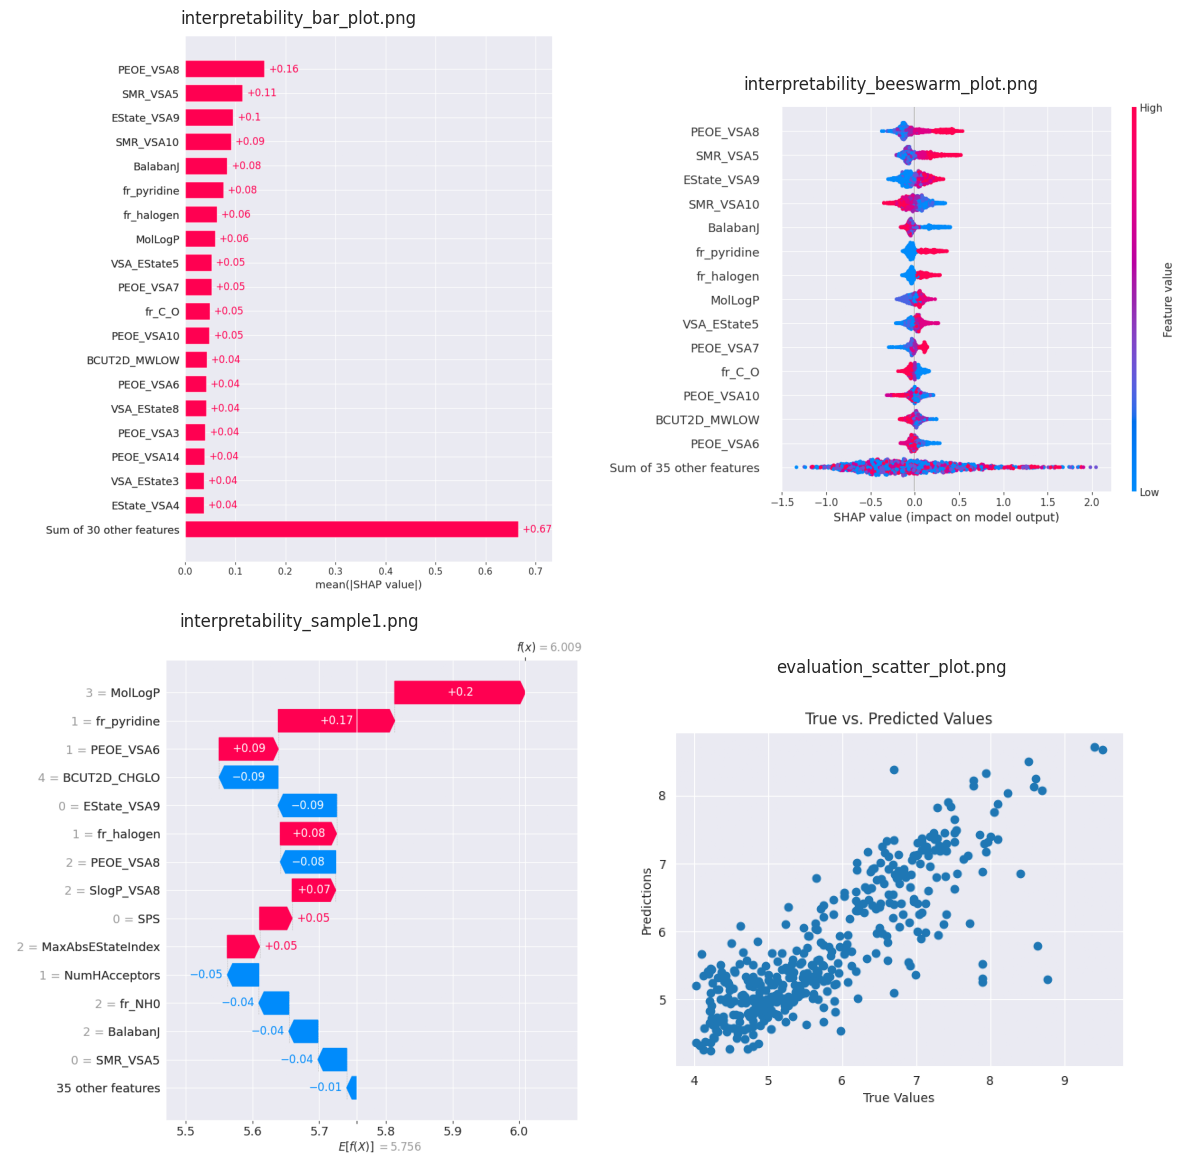

In [17]:
print_images_in_folder(rdkit_select_features_optimized_params)

## Mordred Descriptors 

In [18]:
smiles_train_transformed_mordred, smiles_valid_transformed_mordred = calculate_descriptors('Mordred')

100%|██████████| 417/417 [02:38<00:00,  2.63it/s]


### All Features

#### Default Parameters

In [19]:
mordred_all_features_default_params = set_output_folder('Mordred', 'all_features', use_default_params=True)

train_evaluate(X_train=smiles_train_transformed_mordred, y_train_values=y_train,
               X_valid=smiles_valid_transformed_mordred, y_valid_values=y_valid,
               results_folder=mordred_all_features_default_params,
               select_features=False, default_params=True)

Output folder: ../assets/Mordred_all_features_default_params_True
{'Mean Squared Error': 0.4401, 'Root Mean Squared Error': 0.6634, 'Mean Absolute Error': 0.4821, 'R-squared Score': 0.6679, 'Explained Variance Score': 0.6679}


'../assets/Mordred_all_features_default_params_True'

With 1321 mordred features and default parameters of xgboost, the r2_score achieved is **0.6679**

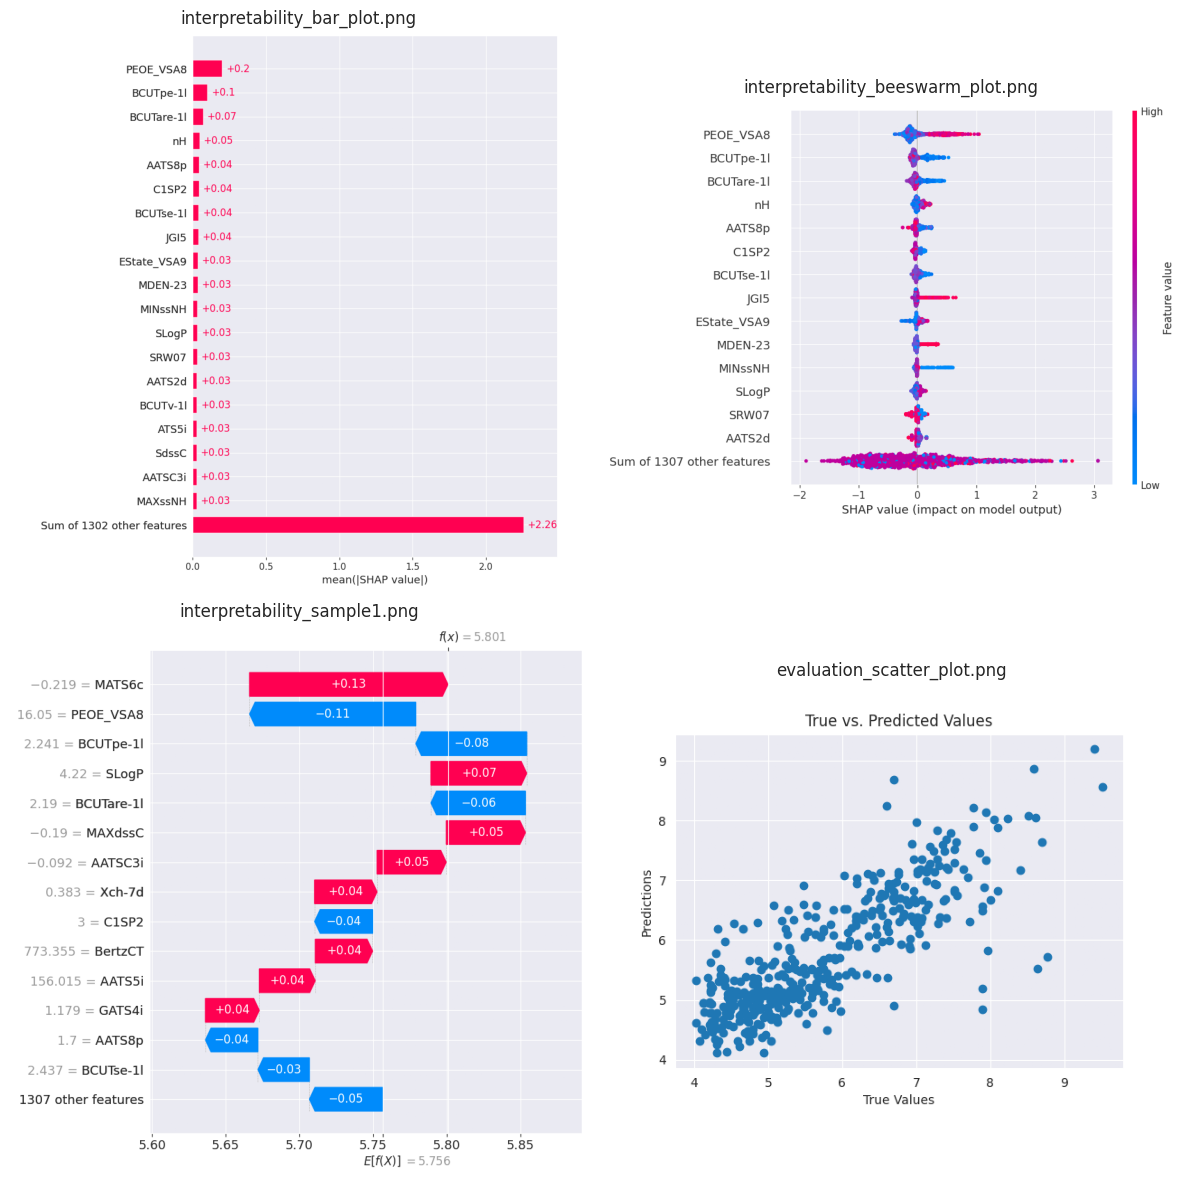

In [20]:
print_images_in_folder(mordred_all_features_default_params)

#### With Optuna

In [21]:
mordred_all_features_optimized_params = set_output_folder('Mordred', 'all_features', use_default_params=False)
train_evaluate(X_train=smiles_train_transformed_mordred, y_train_values=y_train,
               X_valid=smiles_valid_transformed_mordred, y_valid_values=y_valid, 
               results_folder=mordred_all_features_optimized_params,
               select_features=False, default_params=False)

[I 2024-04-09 08:30:34,171] A new study created in memory with name: no-name-262d30a9-0d6e-47a6-b5a6-576fe97d3723


Output folder: ../assets/Mordred_all_features_default_params_False


[I 2024-04-09 08:30:37,989] Trial 0 finished with value: 0.5727970813487743 and parameters: {'lambda': 3, 'alpha': 3, 'gamma': 9, 'learning_rate': 0.19745676158934178, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8, 'n_estimators': 166, 'min_child_weight': 87, 'max_depth': 12, 'subsample': 0.8, 'random_state': 0}. Best is trial 0 with value: 0.5727970813487743.
[I 2024-04-09 08:30:39,465] Trial 1 finished with value: 0.6308630713041838 and parameters: {'lambda': 2, 'alpha': 4, 'gamma': 20, 'learning_rate': 0.25790328201564844, 'colsample_bytree': 0.4, 'colsample_bynode': 0.4, 'n_estimators': 73, 'min_child_weight': 58, 'max_depth': 11, 'subsample': 0.8, 'random_state': 42}. Best is trial 0 with value: 0.5727970813487743.
[I 2024-04-09 08:30:42,628] Trial 2 finished with value: 0.6213428177131906 and parameters: {'lambda': 1, 'alpha': 4, 'gamma': 20, 'learning_rate': 0.33460345727262236, 'colsample_bytree': 0.6, 'colsample_bynode': 0.8, 'n_estimators': 170, 'min_child_weight': 50, 'ma

Best parameters for XGBoost: {'lambda': 0, 'alpha': 0, 'gamma': 0, 'learning_rate': 0.0822423075244123, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'n_estimators': 194, 'min_child_weight': 16, 'max_depth': 15, 'subsample': 0.8, 'random_state': 0}
{'Mean Squared Error': 0.3997, 'Root Mean Squared Error': 0.6322, 'Mean Absolute Error': 0.4527, 'R-squared Score': 0.6984, 'Explained Variance Score': 0.6984}


'../assets/Mordred_all_features_default_params_False'

With 1321 mordred features and using optuna with 200 trials, the r2_score achieved is; **0.6958**. Higher than when trained with default parameters.

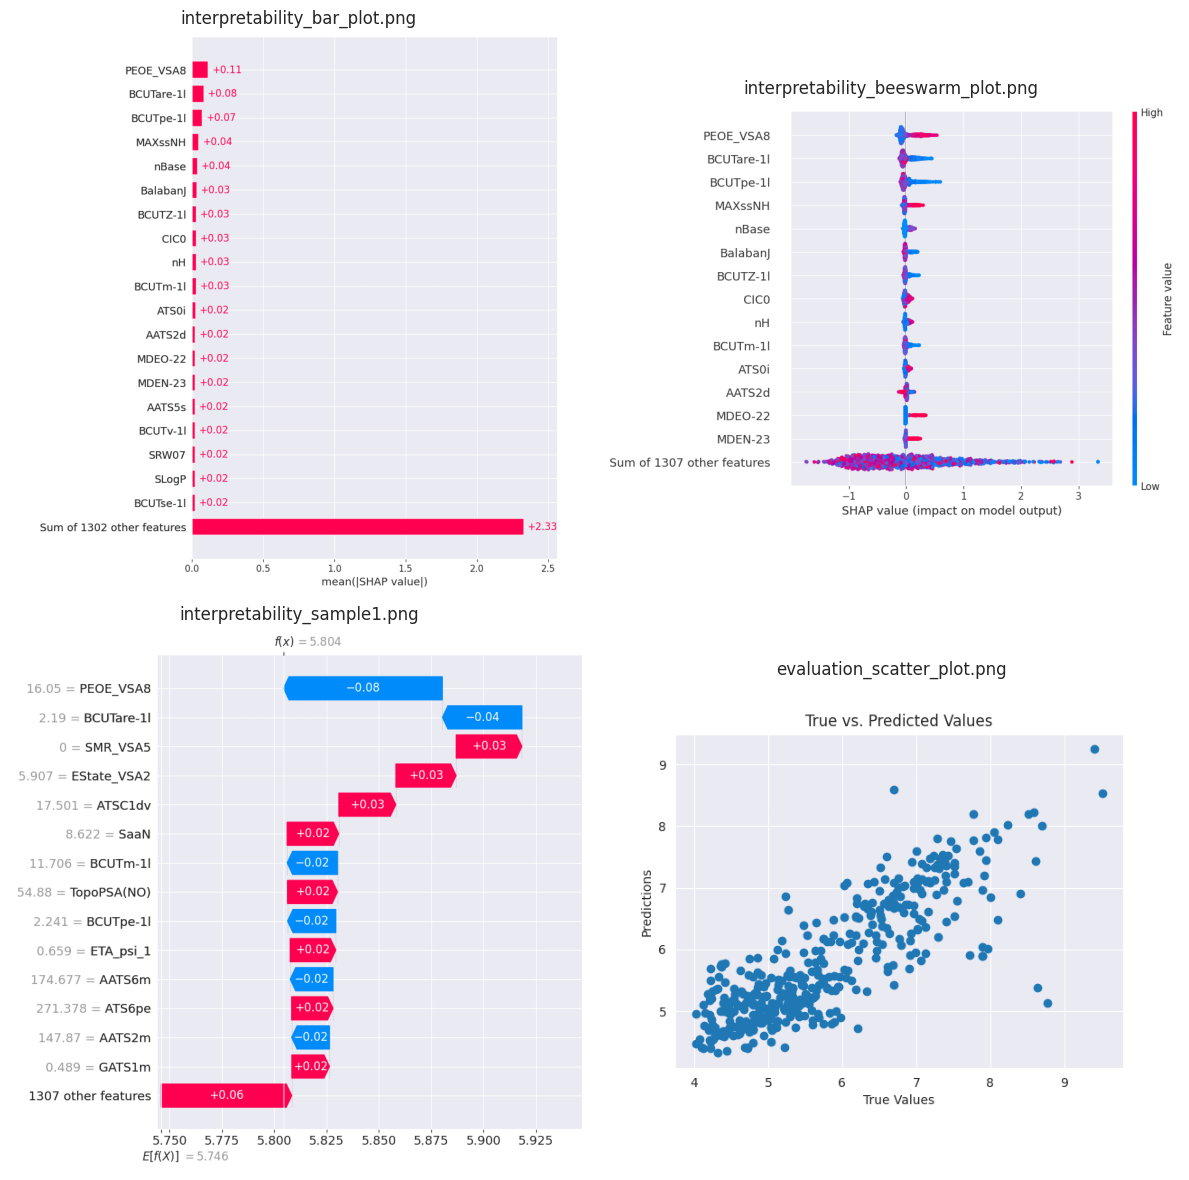

In [22]:
print_images_in_folder(mordred_all_features_optimized_params)

### Select Features

Out of 1321 features from mordred, a corr_limit of 0.80 gives us a total of **253 selected features**.

#### Train with Default Parameters

In [23]:
mordred_select_features_default_params = set_output_folder('Mordred', 'select_features', use_default_params=True)
    
train_evaluate(X_train=smiles_train_transformed_mordred, y_train_values=y_train, 
               X_valid=smiles_valid_transformed_mordred, y_valid_values=y_valid,
               results_folder= mordred_select_features_default_params, 
               select_features=True, default_params=True)

Output folder: ../assets/Mordred_select_features_default_params_True
featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []
Loaded input data. Shape = (1665, 1321)
#### Starting featurewiz transform for train data ####
    Single_Label Regression problem 
Shape of dataset: (1665, 1321). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (1665, 1321)
    Single_Label Regression problem 
Starting SULOV with 1321 features...
    there are no null values in dataset...
    there are no null values in target column...
Completed SULOV. 453 features selected
Performing recursive XGBoost feature selection from

'../assets/Mordred_select_features_default_params_True'

With 253 selected mordred features and default parameters of xgboost, the r2_score achieved is **0.6247**. This is lower than when trained with all features and default parameters.

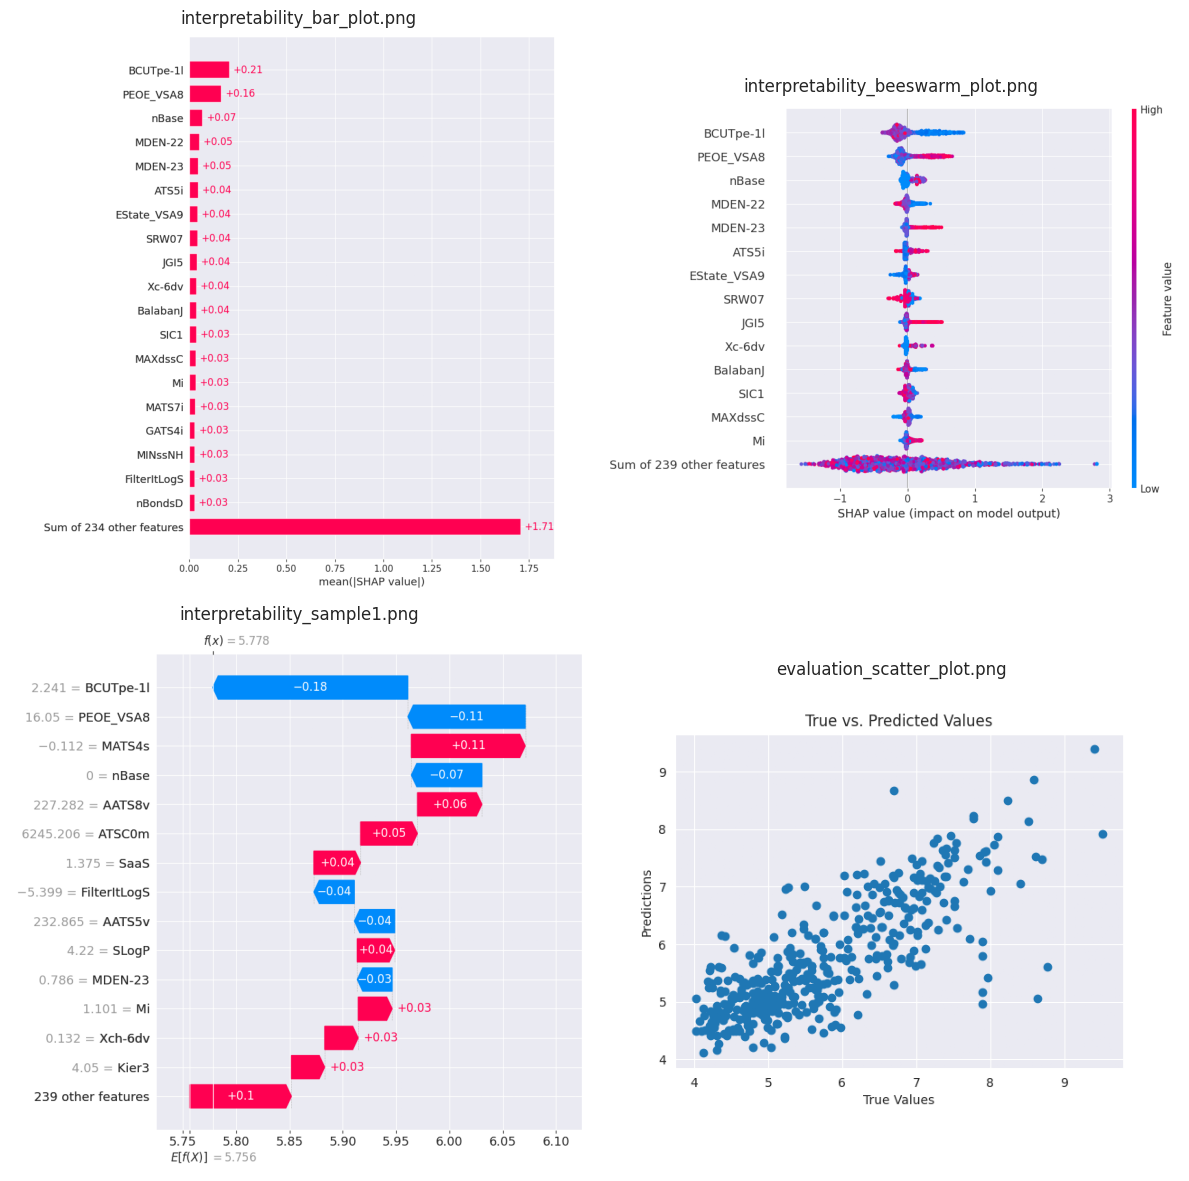

In [24]:
print_images_in_folder(mordred_select_features_default_params)

#### Train with Optuna

In [25]:
mordred_select_features_optimized_params = set_output_folder('Mordred', 'select_features', use_default_params=False)
train_evaluate(X_train=smiles_train_transformed_mordred, y_train_values=y_train,
               X_valid=smiles_valid_transformed_mordred, y_valid_values=y_valid,
               results_folder=mordred_select_features_optimized_params, 
               select_features=True, default_params=False)

Output folder: ../assets/Mordred_select_features_default_params_False
featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []
Loaded input data. Shape = (1665, 1321)
#### Starting featurewiz transform for train data ####
    Single_Label Regression problem 
Shape of dataset: (1665, 1321). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (1665, 1321)
    Single_Label Regression problem 
Starting SULOV with 1321 features...
    there are no null values in dataset...
    there are no null values in target column...
Completed SULOV. 453 features selected
Performing recursive XGBoost feature selection fro

[I 2024-04-09 08:51:37,664] A new study created in memory with name: no-name-deee0857-d762-4dc9-a1c3-142b562d5ee0


    time taken to run entire featurewiz = 37 second(s)
Recursive XGBoost selected 253 features...
#### Starting featurewiz transform for test data ####
Loaded input data. Shape = (417, 1321)
#### Starting lazytransform for test data ####
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (417, 1321)
Returning dataframe with 253 features 
Selected Features:  ['PEOE_VSA8', 'BCUTpe-1l', 'nBase', 'BCUTc-1h', 'ATSC2dv', 'Xc-6dv', 'SRW07', 'EState_VSA9', 'BalabanJ', 'MDEN-23', 'ATS5i', 'MINsOH', 'MINssNH', 'nARing', 'JGI5', 'nBondsD', 'SIC1', 'C1SP2', 'AETA_dBeta', 'GATS3c', 'GATS1i', 'MDEN-22', 'ATSC8v', 'FilterItLogS', 'GATS1d', 'BCUTm-1l', 'NssssC', 'AATSC0s', 'GATS4i', 'SlogP_VSA5', 'SssS', 'ETA_dEpsilon_D', 'ATSC1are', 'ATSC7c', 'GATS2m', 'Mi', 'AATS5v', 'VSA_EState3', 'GATS2c', 'TopoPSA', 'JGI6', 'Radius', 'AATSC1c', 'GATS4c', 'AATSC4i', 'ATSC7dv', 'VSA_EState5', 'SpMax_A', 'BCUTc-1l', 'fragCpx', 'AATSC4c', 'SlogP_VSA3', 'AATSC6s', 'MATS7p', 'AATS3v', '

[I 2024-04-09 08:51:38,201] Trial 0 finished with value: 0.5940103126216578 and parameters: {'lambda': 2, 'alpha': 3, 'gamma': 2, 'learning_rate': 0.37590823175182314, 'colsample_bytree': 1.0, 'colsample_bynode': 0.4, 'n_estimators': 50, 'min_child_weight': 98, 'max_depth': 19, 'subsample': 0.5, 'random_state': 42}. Best is trial 0 with value: 0.5940103126216578.
[I 2024-04-09 08:51:38,548] Trial 1 finished with value: 0.6829724284908077 and parameters: {'lambda': 1, 'alpha': 5, 'gamma': 19, 'learning_rate': 0.7834821323029915, 'colsample_bytree': 0.8, 'colsample_bynode': 1.0, 'n_estimators': 138, 'min_child_weight': 75, 'max_depth': 5, 'subsample': 1.0, 'random_state': 42}. Best is trial 0 with value: 0.5940103126216578.
[I 2024-04-09 08:51:38,979] Trial 2 finished with value: 0.6601645968554615 and parameters: {'lambda': 4, 'alpha': 0, 'gamma': 8, 'learning_rate': 0.6513059558262949, 'colsample_bytree': 0.6, 'colsample_bynode': 0.4, 'n_estimators': 166, 'min_child_weight': 54, 'max_d

Best parameters for XGBoost: {'lambda': 3, 'alpha': 0, 'gamma': 0, 'learning_rate': 0.05781238924940944, 'colsample_bytree': 0.5, 'colsample_bynode': 0.5, 'n_estimators': 175, 'min_child_weight': 15, 'max_depth': 17, 'subsample': 1.0, 'random_state': 0}
{'Mean Squared Error': 0.4047, 'Root Mean Squared Error': 0.6361, 'Mean Absolute Error': 0.465, 'R-squared Score': 0.6946, 'Explained Variance Score': 0.6946}


'../assets/Mordred_select_features_default_params_False'

With 253 selected mordred features and using optuna with 200 trials, the r2_score achieved is; **0.6949**. Slightly lower than when trained with 1321 features and optuna.

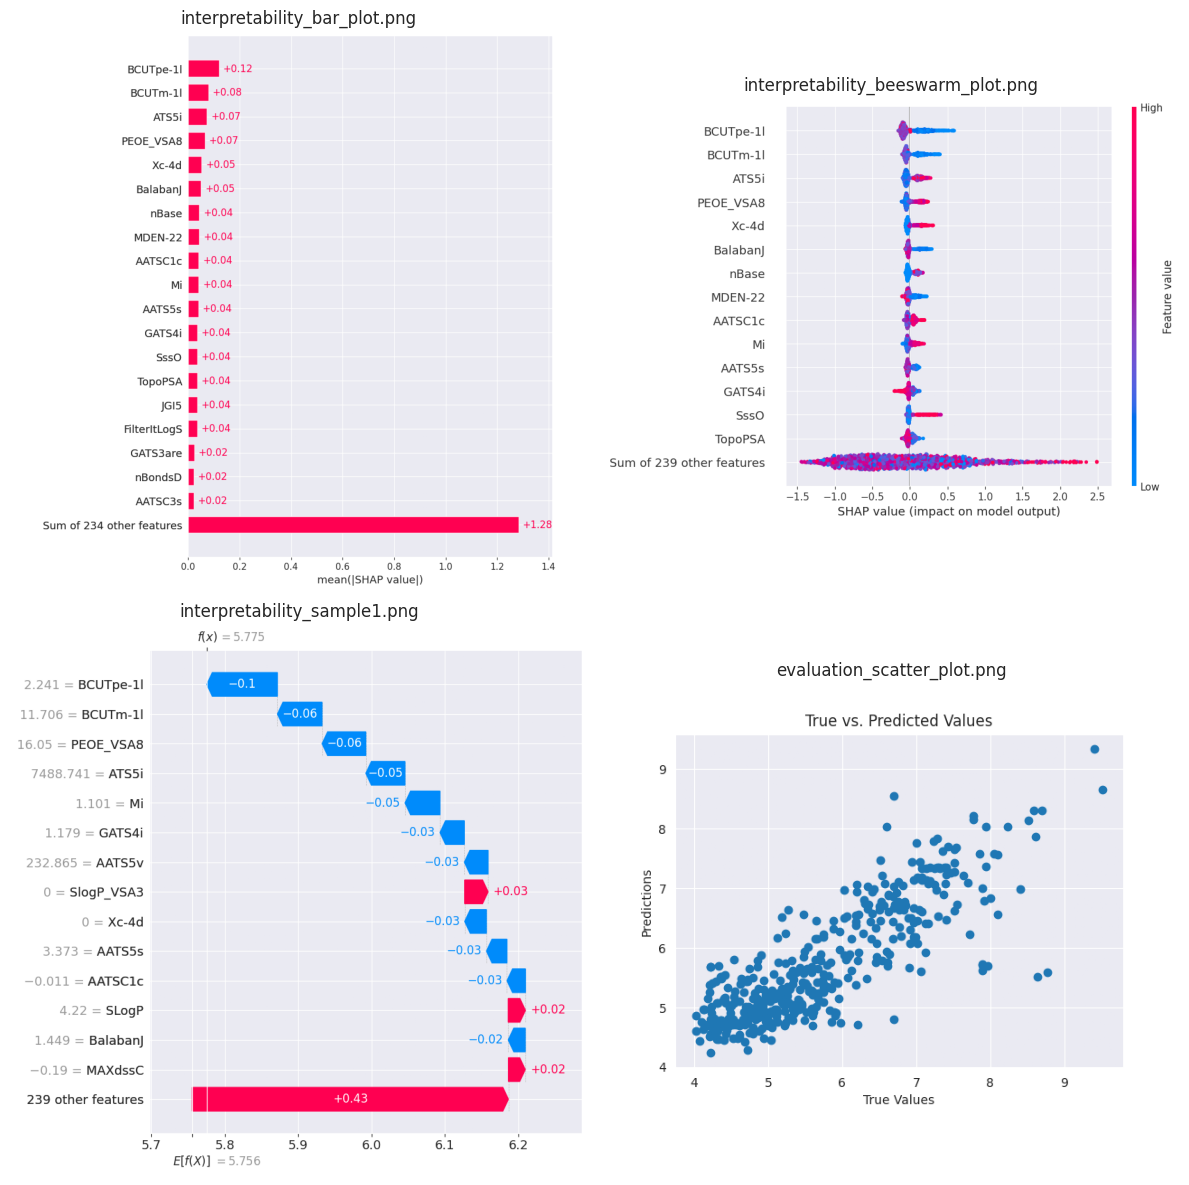

In [26]:
print_images_in_folder(mordred_select_features_optimized_params)

## Top Features in each case

In [27]:
def print_interpretability_bar_plots(descriptor_name):
    # Scan the "../assets" directory for output folders
    output_folders = [os.path.join("../assets", folder) for folder in os.listdir("../assets") if folder.startswith(descriptor_name) and os.path.isdir(os.path.join("../assets", folder))]
    
    for folder in output_folders:
        print(f"Output Folder: {folder}") 
        interpretability_bar_plot_path = os.path.join(folder, 'interpretability_bar_plot.png') 
        interpretability_bar_plot = plt.imread(interpretability_bar_plot_path)
        plt.figure(figsize=(16, 10))
        plt.imshow(interpretability_bar_plot)
        plt.axis('off')
        plt.show()

Output Folder: ../assets/RDKit_all_features_default_params_False


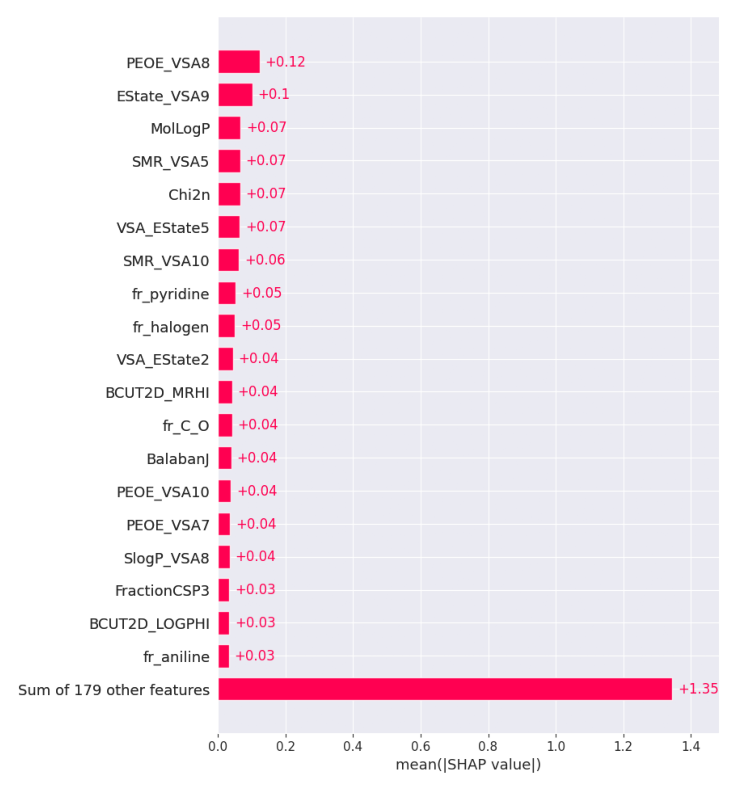

Output Folder: ../assets/RDKit_select_features_default_params_True


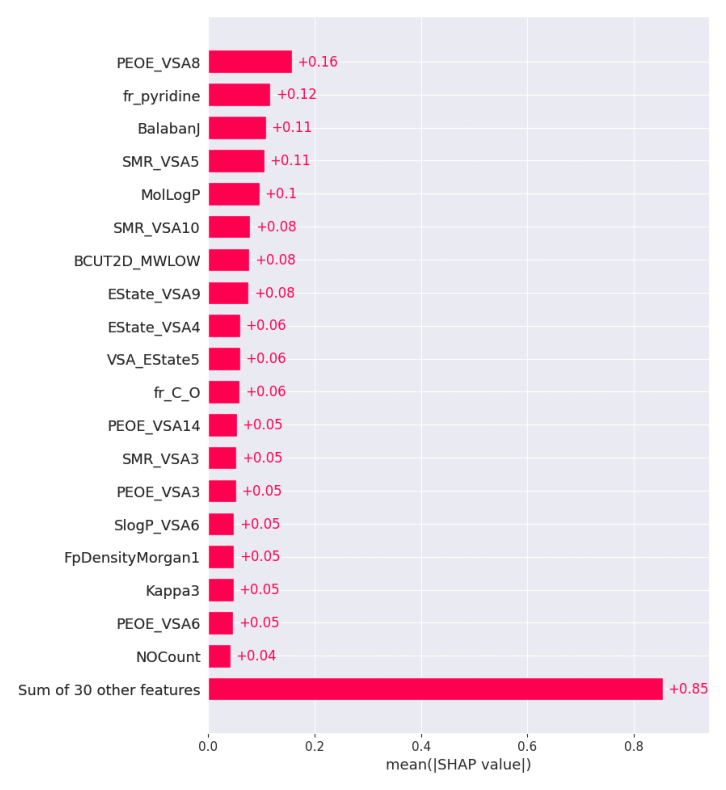

Output Folder: ../assets/RDKit_select_features_default_params_False


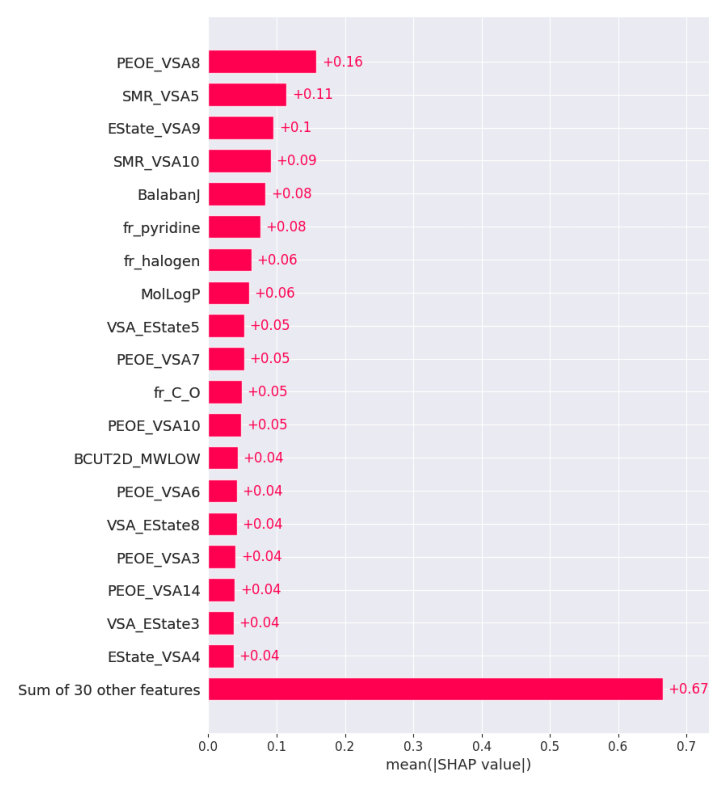

Output Folder: ../assets/RDKit_all_features_default_params_True


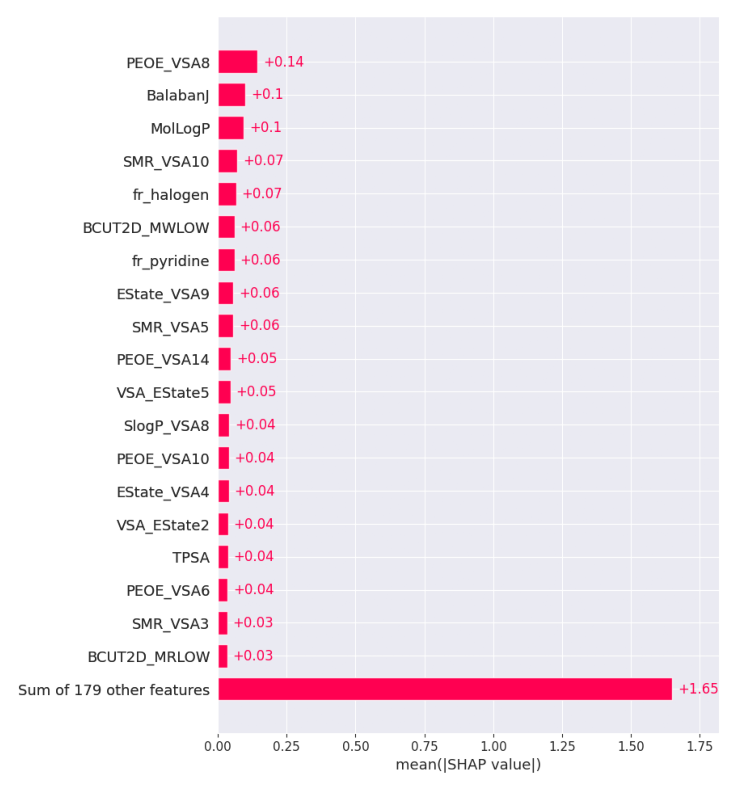

In [28]:
print_interpretability_bar_plots("RDKit")

Output Folder: ../assets/Mordred_all_features_default_params_True


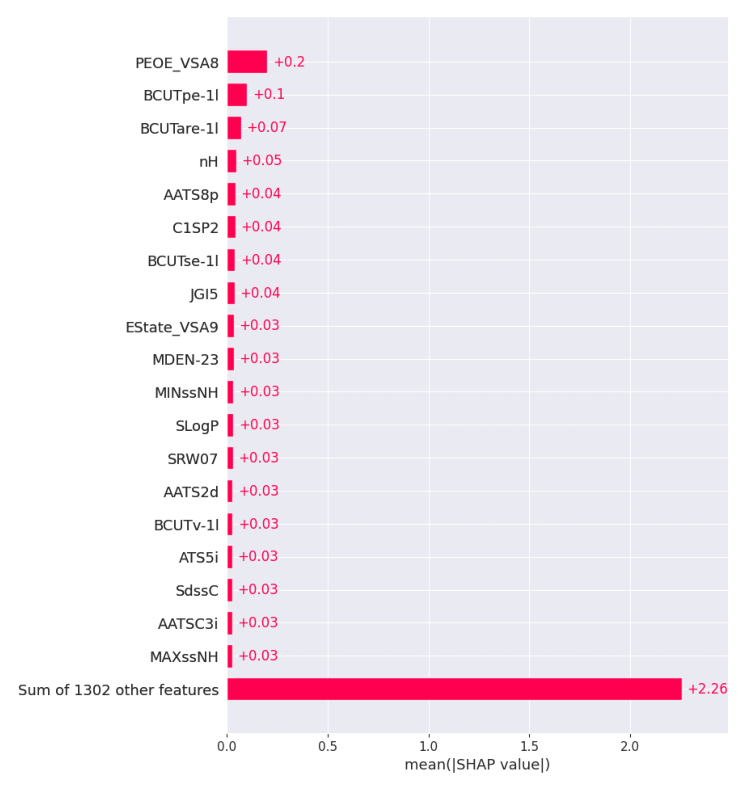

Output Folder: ../assets/Mordred_all_features_default_params_False


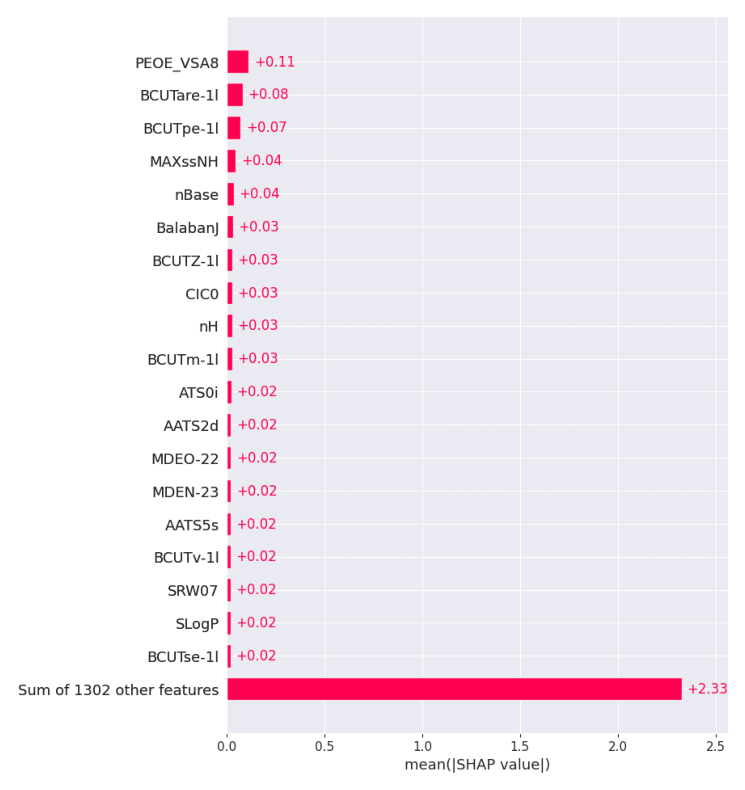

Output Folder: ../assets/Mordred_select_features_default_params_False


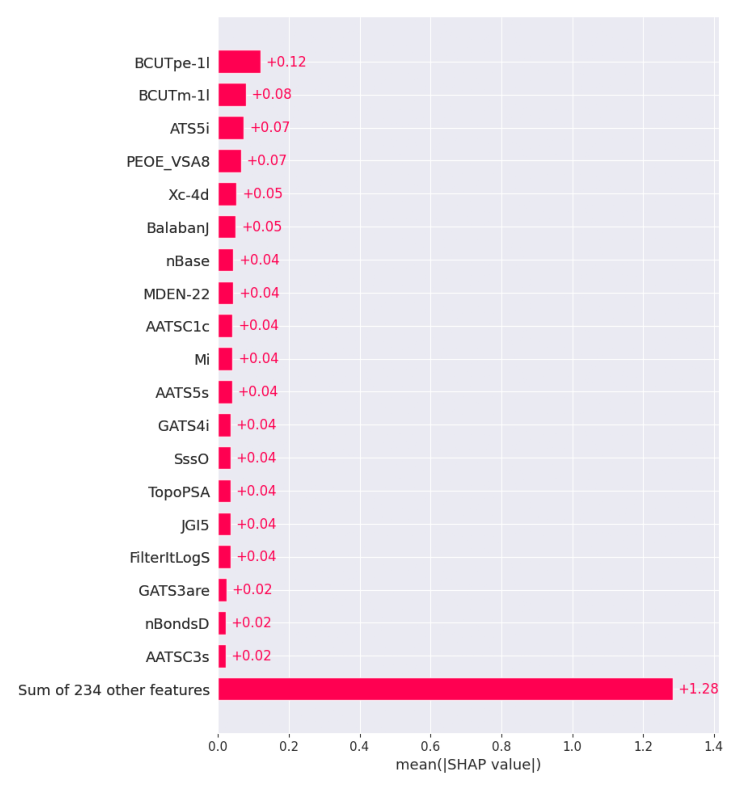

Output Folder: ../assets/Mordred_select_features_default_params_True


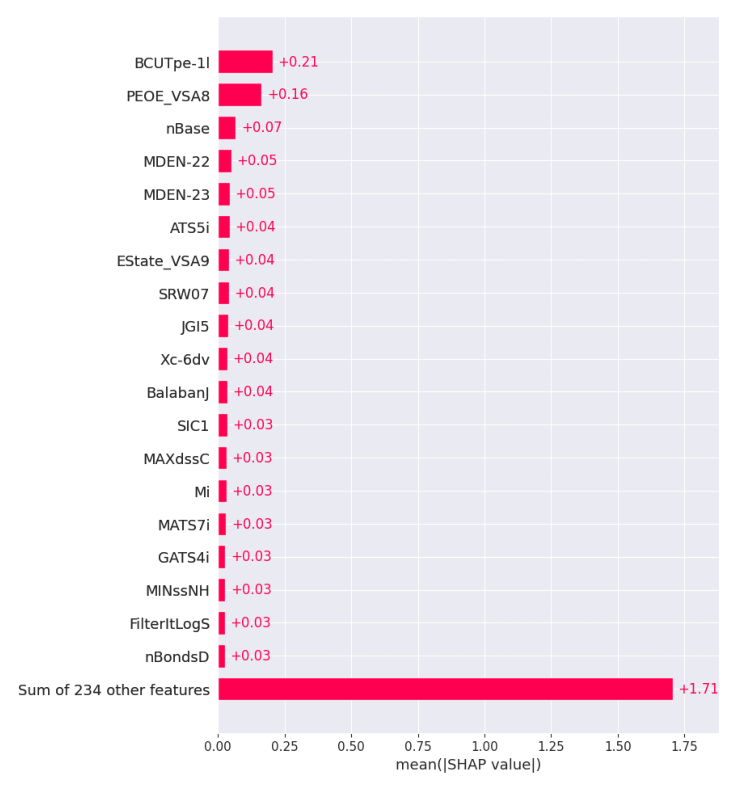

In [29]:
print_interpretability_bar_plots("Mordred")